# EBLR

In [1]:
from lineartree import LinearBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import pandas as pd
from joblib import dump
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/house_prices.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/house_prices.parquet')

In [5]:
y_train = train.SalePrice
X_train = train.drop(columns=['SalePrice'])

In [6]:
y_validation = validation.SalePrice
X_validation = validation.drop(columns=['SalePrice'])

In [7]:
scaler = StandardScaler().fit(X_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [9]:
y_train_scaled = y_train/1000
y_validation_scaled = y_validation/1000

In [10]:
max_depth = [1, 2, 3]
n_est = [3, 5, 7, 9, 11, 13, 15]
base_est =  [LinearRegression(), Ridge(), Lasso(), ElasticNet(l1_ratio=0.25), ElasticNet(l1_ratio=0.5), ElasticNet(l1_ratio=0.75)]
loss = ['linear', 'square']

In [11]:
models_list = []
for n in n_est:
    for i in max_depth:
        for est in base_est:
            for l in loss:
                models_list.append(LinearBoostRegressor(base_estimator=est, n_estimators=n, max_depth=i, loss=l))

In [12]:
names_list = []
for n in n_est:
    for depth in max_depth:
        for est in base_est:
            for l in loss:
                if isinstance(est, LinearRegression):
                    name = f'EBLR_{depth}_{n}_{l}'
                elif isinstance(est, Ridge):
                    name = f'EBLR_{depth}_{n}_{l}_l2'
                elif isinstance(est, Lasso):
                    name = f'EBLR_{depth}_{n}_{l}_l1'
                elif isinstance(est, ElasticNet):
                    name = f'EBLR_{depth}_{n}_{l}_en_{est.l1_ratio}'
                else:
                    raise ValueError('Unknown base estimator type')

                names_list.append(name)

In [13]:
metrics = regression(models_list, names_list, '../../../data/metrics/house_prices/eblr.csv', X_train_scaled, y_train_scaled, X_validation_scaled, y_validation_scaled, metrics={})
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
EBLR_1_3_linear,0.340923,16.555650,6955.746807,41914.338464
EBLR_1_3_square,0.324649,19.066982,51.002664,167.492068
EBLR_1_3_linear_l2,0.045042,17.256765,37.728859,118.632276
EBLR_1_3_square_l2,0.042885,19.086004,36.582092,91.669729
EBLR_1_3_linear_l1,0.058845,21.594142,36.050274,66.944691
...,...,...,...,...
EBLR_3_15_square_en_0.25,0.347801,24.457736,35.989725,47.150677
EBLR_3_15_linear_en_0.5,0.340246,23.571806,35.725291,51.559417
EBLR_3_15_square_en_0.5,0.343057,23.571806,35.725291,51.559417
EBLR_3_15_linear_en_0.75,0.337088,22.560388,35.706110,58.269043


In [14]:
metrics.sort_values(by='Validation_RMSE').head(15)

,Run_Time,Train_RMSE,Validation_RMSE,delta%
EBLR_1_7_linear_l2,0.096741,16.037226,33.741618,110.395605
EBLR_2_15_linear_l2,0.235371,14.943561,33.786872,126.096517
EBLR_2_13_linear_l2,0.202966,15.008150,33.829218,125.405650
EBLR_2_13_square_l2,0.270277,15.323478,34.475137,124.982454
EBLR_2_15_square_l2,0.228990,14.955428,34.630548,131.558384
EBLR_2_11_square_l2,0.182713,15.639036,34.840732,122.780567
EBLR_3_7_square_l2,0.139820,16.029572,35.115632,119.067802
EBLR_2_7_linear_l2,0.106816,16.804837,35.332254,110.250506
EBLR_2_9_linear_l2,0.136624,15.659617,35.504093,126.723894
EBLR_3_15_linear_l2,0.274583,15.301767,35.591150,132.595033


We are going to choose **EBLR_1_7_linear_l2**, that is the model that fits 7 trees of maximum depth 1 on errors (includes 7 new features) with linear loss

In [23]:
test =  pd.read_parquet('../../../data/model_input/test_sets/house_prices.parquet')

In [24]:
y_test = test.SalePrice
X_test = test.drop(columns=['SalePrice'])

In [25]:
retrain = pd.concat([train, validation])

In [26]:
y_retrain = retrain.SalePrice
X_retrain = retrain.drop(columns=['SalePrice'])

In [27]:
y_retrain_scaled = y_retrain/1000
y_test_scaled = y_test/1000

In [28]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [29]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [42]:
model = LinearBoostRegressor(base_estimator=Ridge(), max_depth=1, n_estimators=7).fit(X_retrain_scaled, y_retrain_scaled)

In [43]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test_scaled, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 21.2598


In [44]:
dump(model, 'best_eblr.joblib')

['best_eblr.joblib']

In [45]:
with open('../../../data/metrics/house_prices/final_RMSE.txt', 'a') as f:
    f.write('\nEBLR, '+ str(rmse))

Let's take a look to the final model:

In [51]:
print(f'Initial number of features: {X_retrain.shape[1]}\nFinal number of features: {model.transform(X_retrain_scaled).shape[1]}')

Initial number of features: 303
Final number of features: 310


So we have 7 new features:

In [54]:
error_trees = model._trees

#### New Feature 1

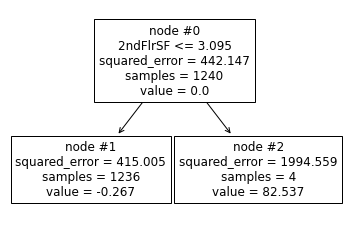

In [64]:
plot_tree(error_trees[0], node_ids=True, feature_names=X_retrain.columns);

In [55]:
pred = np.abs(error_trees[0].predict(X_retrain_scaled))
worst_leaf = np.argmax(pred)
error_path = error_trees[0].decision_path(X_retrain_scaled[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

In [123]:
path1 = []
for i in indexes[:-1]:
    path1.append(str(X_retrain.columns[error_trees[0].tree_.feature[i]])+' <= '+str(error_trees[0].tree_.threshold[i]))
path1.append('leaf value: '+str(model._leaves[0]))

In [124]:
path1

['2ndFlrSF <= 3.0953058004379272', 'leaf value: 82.53662109375']

Thus, in the second iteration of the loop, the algorithm fits a linear regression with ElasticNet penalty for X_retrain_scaled with a new column given by the new feature that assigns $0$ to samples that verify $2ndFlrSF\leq 3.0953058004379272$ and $1$ to those that do not.

In [116]:
pred_tree = np.abs(error_trees[0].predict(X_retrain_scaled.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[0]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_retrain_scaled, pred_tree], axis=1)

#### New Feature 2

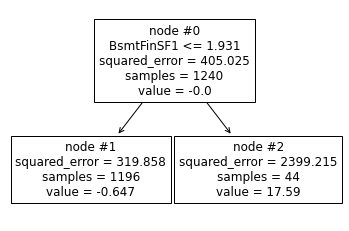

In [118]:
plot_tree(error_trees[1], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1']);

In [119]:
pred = np.abs(error_trees[1].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[1].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

In [129]:
path2 = []
for i in indexes[:-1]:
    path2.append(str(list(list(X_retrain.columns)+['New_Feature_1'])[error_trees[1].tree_.feature[i]])+' <= '+str(error_trees[1].tree_.threshold[i]))
path2.append('leaf value: '+str(model._leaves[1]))

In [130]:
path2

['BsmtFinSF1 <= 1.930666446685791', 'leaf value: 17.589646231911402']

Reasoning like before, we add a new binary column given by the rule $BsmtFinSF1 \leq 1.930666446685791$; 0 if true, 1 if false

In [131]:
pred_tree = np.abs(error_trees[1].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[1]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 3

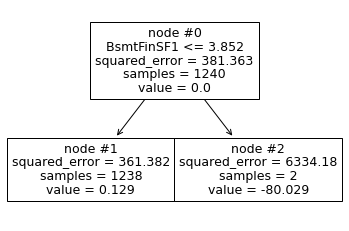

In [134]:
plot_tree(error_trees[2], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2']);

In [135]:
pred = np.abs(error_trees[2].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[2].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

In [136]:
path3 = []
for i in indexes[:-1]:
    path3.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2'])[error_trees[2].tree_.feature[i]])+' <= '+str(error_trees[2].tree_.threshold[i]))
path3.append('leaf value: '+str(model._leaves[2]))

In [137]:
path3

['BsmtFinSF1 <= 3.85219943523407', 'leaf value: 80.02922821044922']

Again we make a new column with 1 if the condition is false

In [138]:
pred_tree = np.abs(error_trees[2].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[2]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 4

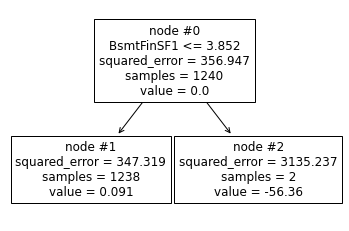

In [139]:
plot_tree(error_trees[3], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3']);

In [140]:
pred = np.abs(error_trees[3].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[3].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

In [141]:
path4 = []
for i in indexes[:-1]:
    path4.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3'])[error_trees[3].tree_.feature[i]])+' <= '+str(error_trees[3].tree_.threshold[i]))
path4.append('leaf value: '+str(model._leaves[3]))

path4

['BsmtFinSF1 <= 3.85219943523407', 'leaf value: 56.360267639160156']

Again we make a new column with 1 if the condition is false

In [142]:
pred_tree = np.abs(error_trees[3].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[3]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 5

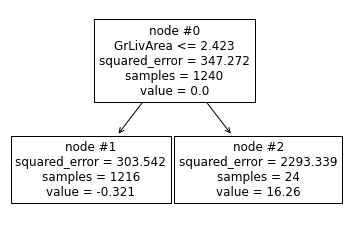

In [144]:
plot_tree(error_trees[4], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4']);

In [145]:
pred = np.abs(error_trees[4].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[4].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path5 = []
for i in indexes[:-1]:
    path5.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4'])[error_trees[4].tree_.feature[i]])+' <= '+str(error_trees[4].tree_.threshold[i]))
path5.append('leaf value: '+str(model._leaves[4]))

path5

['GrLivArea <= 2.4226396083831787', 'leaf value: 16.259963470458985']

Again we make a new column with 1 if the condition is false

In [146]:
pred_tree = np.abs(error_trees[4].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[4]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 6

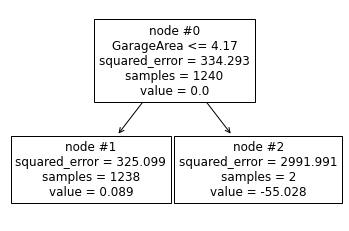

In [147]:
plot_tree(error_trees[5], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4, New_Feature_5']);

In [148]:
pred = np.abs(error_trees[5].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[5].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path6 = []
for i in indexes[:-1]:
    path6.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4, New_Feature_5'])[error_trees[5].tree_.feature[i]])+' <= '+str(error_trees[5].tree_.threshold[i]))
path6.append('leaf value: '+str(model._leaves[5]))

path6

['GarageArea <= 4.170212984085083', 'leaf value: 55.02831994628906']

Again we make a new column with 1 if the condition is false

In [149]:
pred_tree = np.abs(error_trees[5].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[5]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 7

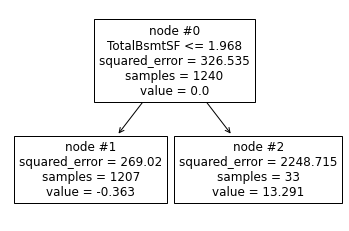

In [150]:
plot_tree(error_trees[6], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4, New_Feature_5, New_Feature_6']);

In [151]:
pred = np.abs(error_trees[6].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[6].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path7 = []
for i in indexes[:-1]:
    path7.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4, New_Feature_5, New_Feature_6'])[error_trees[6].tree_.feature[i]])+' <= '+str(error_trees[6].tree_.threshold[i]))
path7.append('leaf value: '+str(model._leaves[6]))

path7

['TotalBsmtSF <= 1.967915654182434', 'leaf value: 13.290722401012076']

Again we make a new column with 1 if the condition is false. Finally, we fit the linear model:

In [182]:
top_threshold = 5
top_coefficients = [coef for coef in model.base_estimator_.coef_.ravel() if abs(coef) > top_threshold]
top_features = [name for name, coef in zip(X_retrain.columns, model.base_estimator_.coef_.ravel()) if abs(coef) > top_threshold]

In [183]:
labels = [' ' if feature not in top_features else feature for feature in X_retrain.columns]+['New_Feature_1']+['New_Feature_2']+['New_Feature_3']+['New_Feature_4']+['New_Feature_5']+['New_Feature_6']+['New_Feature_7']

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_1664/676169912.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90, ha='right')


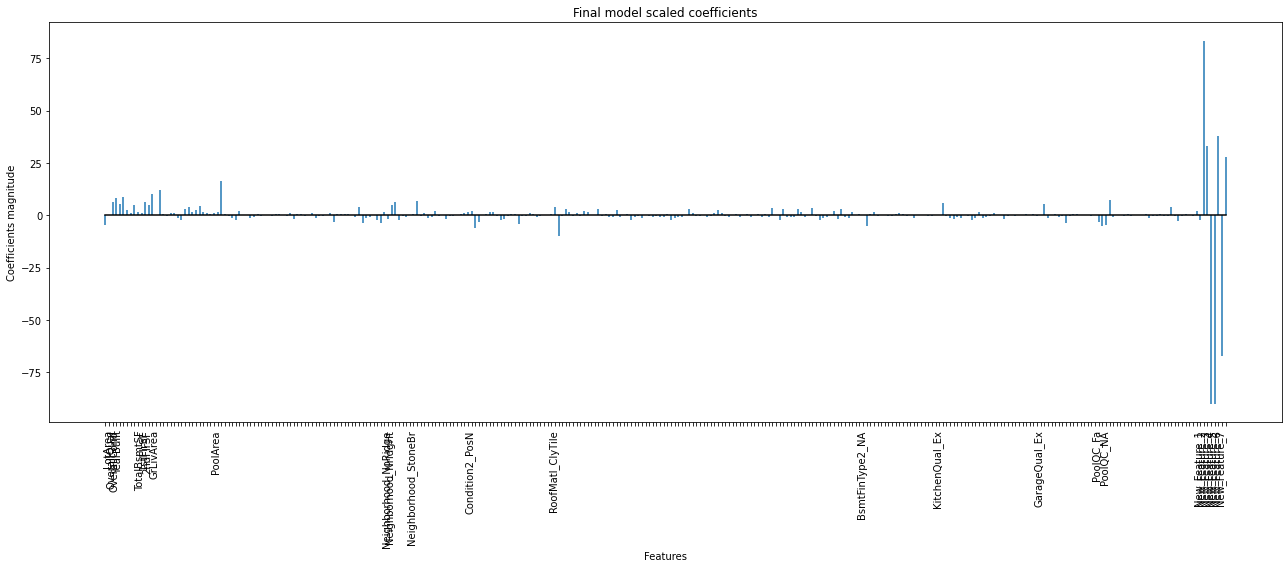

In [184]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.stem(list(list(X_retrain.columns)+['New_Feature_1']+['New_Feature_2']+['New_Feature_3']+['New_Feature_4']+['New_Feature_5']+['New_Feature_6']+['New_Feature_7']), model.base_estimator_.coef_.ravel(), markerfmt=' ', basefmt='k-')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Final model scaled coefficients')
ax.set_xticklabels(labels, rotation=90, ha='right')
plt.tight_layout()
plt.show()

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_1664/3753368203.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain_scaled.min(), y_retrain_scaled.max()], [y_retrain_scaled.min(), y_retrain_scaled.max()],


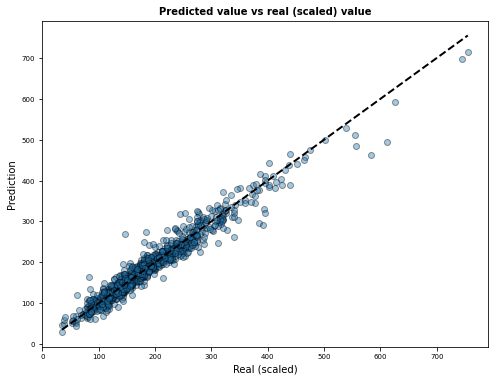

In [185]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain_scaled

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain_scaled, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain_scaled.min(), y_retrain_scaled.max()], [y_retrain_scaled.min(), y_retrain_scaled.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real (scaled) value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real (scaled)')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)